In [1]:
import torch
import sys
import os
import matplotlib.pyplot as plt
sys.path.insert(0,"..")
from src import CENTRES_DIR, MODELS_DIR, LOG_DIR

2020-12-16 16:56:26,578 - root - INFO - Autodiscovery repository dir: /home/nina/ML/fresh
2020-12-16 16:56:26,579 - root - INFO - /home/nina/ML/fresh/dataset


In [2]:
experiment = "CentreTest" # what was trained
test_name = 'validation' # on what we test
EXP_DIR = os.path.join(LOG_DIR, experiment)
MDL_DIR = os.path.join(MODELS_DIR, experiment)

In [3]:
from Models import CentresModel, get_mask
from Training import CentresTrainer
from Dataset import add_gradients

image_model = CentresModel().to(device='cpu')
LossModel = torch.nn.L1Loss(reduction='mean') #L2Loss, KLdivergence
trainer = CentresTrainer( image_model = image_model,
                            loss_model = LossModel,
                            lr=0.0)

Optimizer: ADAM
Learning rate =  0.0


In [4]:
loaded = torch.load(f"{MDL_DIR}/{trainer.get_model_filename()}_epoch99.th")
image_model.load_state_dict(loaded)

<All keys matched successfully>

In [5]:
import pickle as pkl
with open("/home/nina/ML/fresh/dataset_centres/video_chaos1/VidChaos1050.pkl","rb") as f:
    example = pkl.load(f)
example['in'].shape

(5, 86, 86)

In [6]:
# add gradients
with_gradients = add_gradients(example['in'])
# but inputs on GPU
gpu_in = torch.tensor(with_gradients.astype("float32"),device='cpu')
# RUN
%time out = image_model(gpu_in.unsqueeze(0)) #unsqueeze adds batch dimension
out_cpu = out.detach()#.cpu().numpy()

CPU times: user 67.2 ms, sys: 0 ns, total: 67.2 ms
Wall time: 11 ms


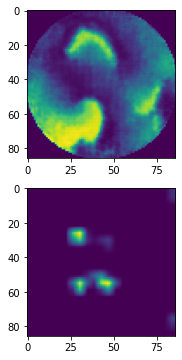

In [7]:
fix, ax = plt.subplots(2,figsize=(3,6))
ax[0].imshow(example['in'][0])
ax[1].imshow(out_cpu)

In [6]:
epoch=99
trainer.load_models(epoch, MDL_DIR)
trainer.new_log(os.path.join(EXP_DIR,"test_loss.dat"), log_dir=os.path.join(EXP_DIR,test_name)) #set logger

Model loaded succesfully


In [26]:
from Dataset import get_stream_centres
stream_valid = get_stream_centres(CENTRES_DIR, 'validation_set.dat')

Dataset folder:  /home/nina/ML/fresh/dataset_centres
Dataset list path:  validation_set.dat
Dataset size:  1869
Dataset output type: 3d density maps


In [27]:
mask = get_mask()
for data in stream_valid:
    trainer.predict(data,mask)
# this for loop loads batches of images and outputs logs *.th of 3 types
# "grnd" (ground truth), "pred" (model prediction) and "sign" (signature frame, I guess)

In [28]:
import numpy as np

def get_losses(files):
    loss = []
    for file in files:
        file_base = file[:-7]
        grnd = torch.load(os.path.join(log_dir,f"{file_base}grnd.th"))
        pred = torch.load(os.path.join(log_dir,f"{file_base}pred.th")).detach()
        loss.append(LossModel(pred,grnd).data.numpy())
    return np.array(loss)

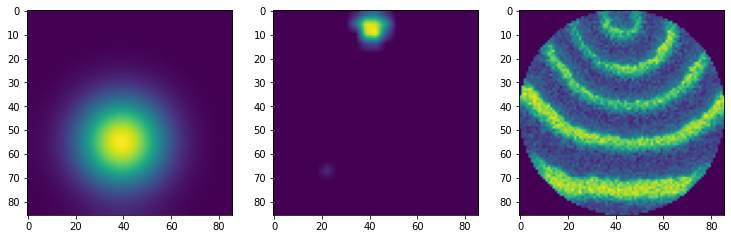

In [30]:
import glob

log_dir = os.path.join(LOG_DIR, experiment, test_name)

files = glob.glob(os.path.join(log_dir, '*grnd.th'))
loss = get_losses(files) #evaluate losses on all test samples
idx = 87#np.argmax(loss) #find the worst(max) or the best(min), or any index
file_base = files[idx][:-7]

img_grnd = torch.load(os.path.join(log_dir,f"{file_base}grnd.th"))
img_pred = torch.load(os.path.join(log_dir,f"{file_base}pred.th")).detach()
img_sign = torch.load(os.path.join(log_dir,f"{file_base}sign.th"))
fig, (ax_grnd,ax_pred,ax_sign) = plt.subplots(1,3,figsize=(12.5,4))
ax_grnd.imshow(img_grnd)
ax_pred.imshow(img_pred)
ax_sign.imshow(img_sign)

In [103]:
files[38]

'/home/nina/ML/fresh/log/CentreTest/video/VidSpiral1071_grnd.th'

(array([1.824e+03, 2.200e+01, 5.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.00127565, 0.01178149, 0.02228733, 0.03279317, 0.04329901,
        0.05380485, 0.06431068, 0.07481652, 0.08532237, 0.09582821,
        0.10633405, 0.11683989, 0.12734573, 0.13785157, 0.1483574 ,
        0.15886325, 0.16936909, 0.17987493, 0.19038077, 0.2008866 ,
        0.21139245], dtype=float32),
 <BarContainer object of 20 artists>)

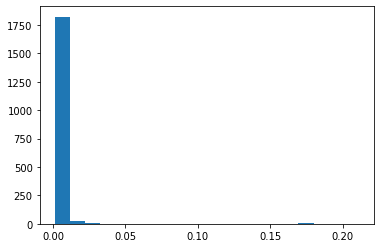

In [14]:
plt.hist(loss,bins=20)

In [20]:
np.where(np.array(loss)>0.02)

(array([  58,   87,   94,  163,  188,  317,  586,  591,  663,  691,  701,
         766,  808,  942,  992,  996, 1097, 1224, 1326, 1377, 1442, 1520,
        1577, 1700, 1744, 1752]),)